In [34]:
from IPython.display import Image

from ccontrol.utils import plot_scores, load_scores

path_images = r'../image'

###  Learning algorithm : Deep Deterministic Policy Gradient (DDPG)

#### Description of the algorithm

DDPG is a **model-free**, **off-policy** **actor-critic** algorithm using deep function approximators that can learn policies in high-dimensional, continuous action spaces.
It is the DQN of the actor-critic algorithms as this algorithm tries to learn a **deterministic policy** with the actor while trying to estimates the action-values (Q-values) using the action from the actor and the critic network.

#### Choosen hyperparameters
- **gamma** ($\gamma $) : $0.97$ a slightly low discount factor that trades more stability for a little bias.
- **actor learning rate** ($\alpha_{actor} $): $10^{-4}$ the classic value from the experiment details of *Continuous control with deep reinforcement learning*.
- **critic learning rate** ($\alpha_{critic} $) : $2 \times 10^{-4}$ a low value (one fifth of what is usually used). This was needed to stabilize the learning.
- **tau**  ($\tau $ ): $5 \times 10^{-4}$ the soft update of the target network parameter. It had a consequential on the stability of the learning. This value is half the one used in the original paper.
- **batch size** : $32$ for 20 agents, $64$ for a single agent. The original value was kept for a single agent and had to be adapted for twenty because of processing time considerations.
- **update rate** : every $5$ steps for 20 agents, every $4$ for a single agent. Define how often the learning step will occur. This parameter was also introduced to stabilize learning. It was slightly elongate for mulptiples agents.
- **buffer type** : Uniform. This type of replay buffer sample it experience following a uniform probability, which means that avery experience have as much chance of being sampled. At first, it was plan to use a prioritized replay buffer but latter it was decided that it would add ttoo much complexity.
- **buffer size** : $10^{4}$, a low value was choosen because of the size of the experiment (only 500 episodes) and in order to slightly favor the latest experiences.
- **noise process** : even if it has been demonstrated that gaussian noise is as efficient, the  Ornstein-Uhlenbeck process of the original paper was prefered. Its parameters were kept the same, ($\sigma = 0.2$ and $\theta = 0.15$).

#### Network model architecture

The **actor** network is composed of **two layers of size $64$** for $\approx 6300$ parameters that map a inputed state to an action. At each layer, a **batch normalization** is applied before the application of the activation functions which are **ReLU**. The use of batch normalization significantly improves the stability of the learning. Finally a **tanh** activation function is applied on top of the output in order to constrain it to the domain of the action space $[-1,1]$. 

The first layer of the **critic** network have $64$ neurons and take a state as input. its output is concaneted to the action which is a vector of size $4$ and is feeded to the second layer of size $64$ also and ouput the Q-value for a tolal of $\approx 6500$ parameters. Similarly, at each layer, a **batch normalization** is applied before the application of the activation functions which are **ReLU**.

The final layer weights and biases of both the actor and critic were initialized from a uniform distribution $[-3 \times 10^{-3},3 \times 10^{-3} ]$. The other layers were initialized from uniform distributions $[-\frac{1}{\sqrt{f}},-\frac{1}{\sqrt{f}}]$ where f is the fan-in of the layer.

The cardinality of the layers were choosen to be power of two as it was often the case in the cases I have study. There is a lot of room for improvment in the architecture ofthe network.

### Plot of the reward
The best result was **111** episodes to solve the environment as displayed below. The environment used contained 20 agents. This run correspond to the one shown in `Continuous_control` in the section *Training 20 agents simultaneously*.

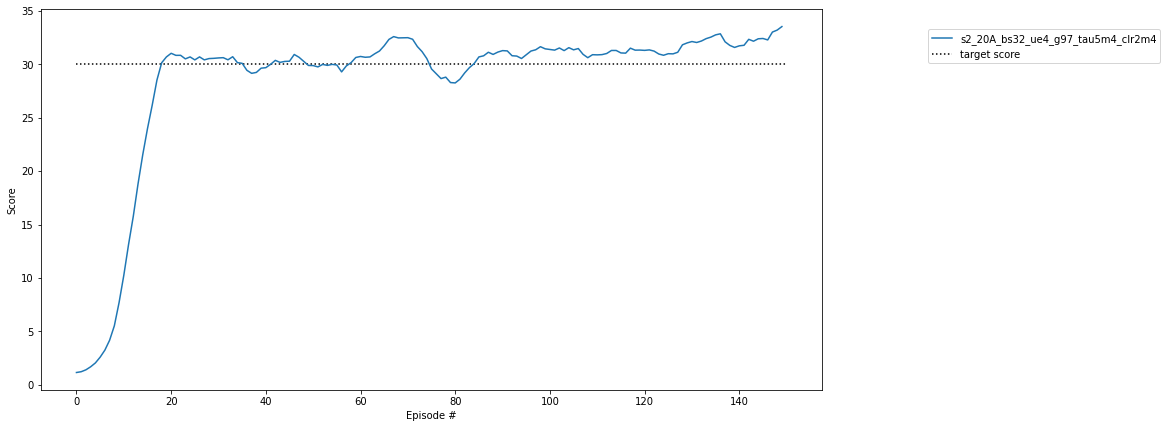

In [23]:
key_20A = 's2_20A_bs32_ue4_g97_tau5m4_clr2m4'
dict_scores = load_scores(key=key_20A)
plot_scores(dict_scores, window_size=10, target_score=30)

### Development of the project

The first implementation of DDPG with th original parameters show no sign of learning in the reacher environment even with a first manual tweaking of the hyperparameters. In order too get a signal to get a direction of progress toward a learning agent, it was decided to switch to a simpler environment. 

Among the easiest enviroment, **Cartpole** was selected (close winner against MountainCar). After some experiment, the addition of batch normalization show the first signs of stable learning as shown in the following score representation where vanilla stand for the same network without batch normalization:

Effect of batch normalization on socre obtain on Cartpole : 



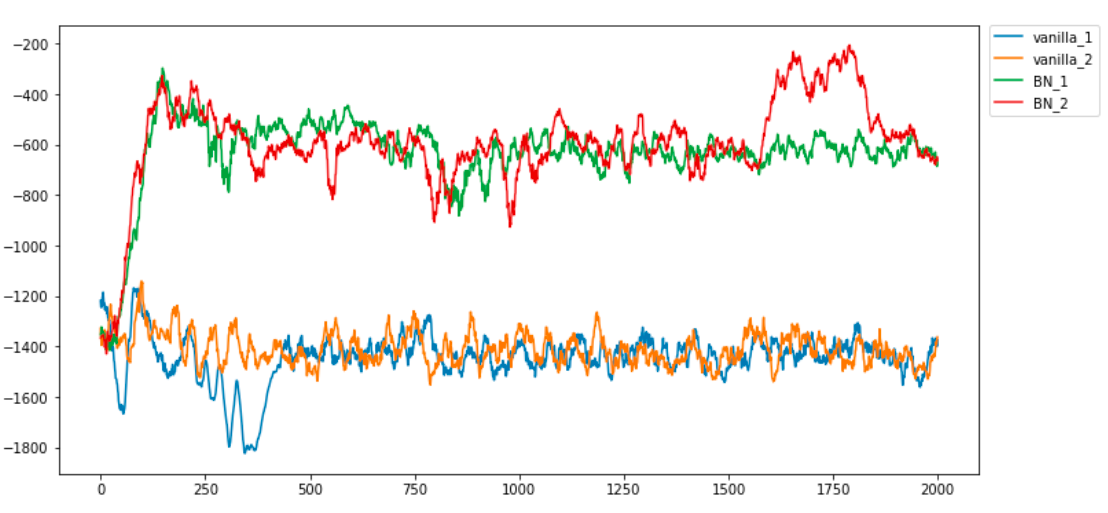

In [37]:
print('Effect of batch normalization on socre obtain on Cartpole : \n')
Image(os.path.join(path_images, 'cartpole_BN_scores.png'), width = 600, height = 400) 

The agent train with batch normalization behave nicely on the cartpole environment as illustrated by the following gif of interaction:

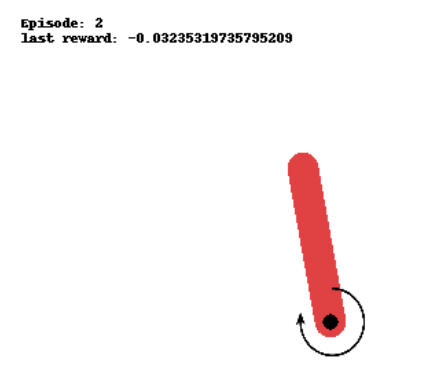

In [53]:
Image(os.path.join(path_images, 'cartpole_interaction.png'), width = 200, height = 200) 

<img src='../output/interaction/test_noise.gif' width="350" align="center">

That result put me on track to reduce the instability of the learning and further experiments with the hyperparameters capable of doing so were conducted in the Reacher environment. Reduction of the discount factor $\gamma$, the target network update$\tau$ and $\alpha$ the learning rate all showed improvments. The following scores representations shows those reserach :

Exploration of the ddpg hyperparameters effect : 



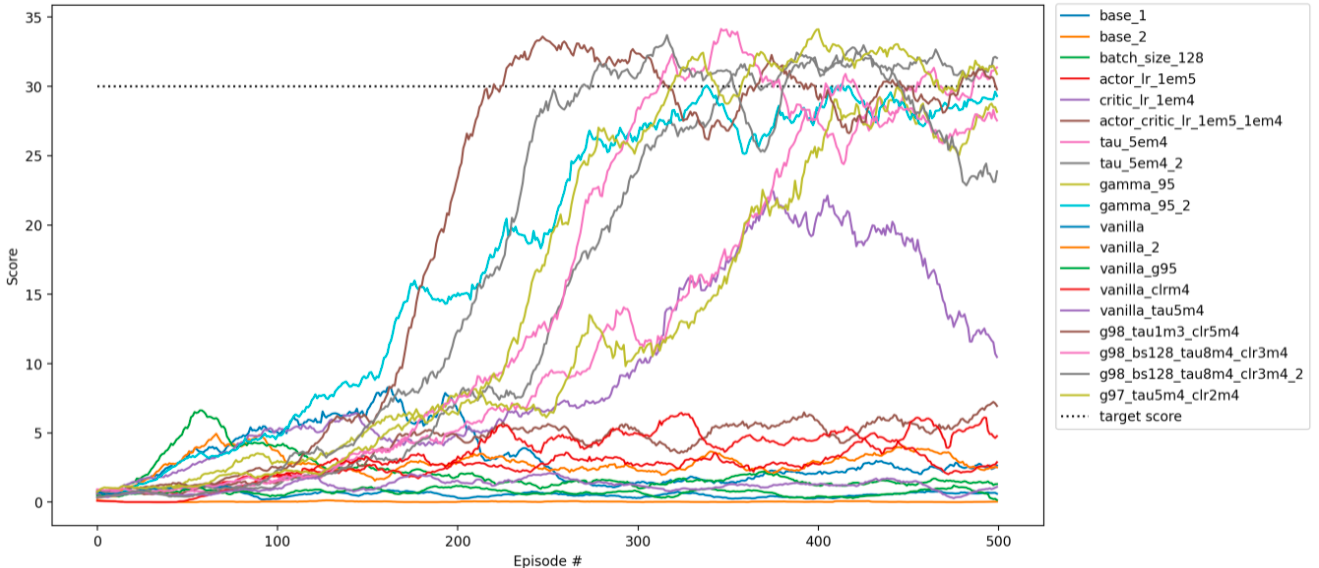

In [50]:
print('Exploration of the ddpg hyperparameters effect : \n')
Image(os.path.join(path_images, 'ddpg_parameters_experiments.png'), width = 1000, height = 1000) 

The results above were all obtained using the **single agent** environment. Some explications for specific run can be insightfull:
- **vanilla_1&2**: training with the hyperparameters found in the original [paper](https://arxiv.org/pdf/1509.02971.pdf). The agent did not learn at all.
- **base_1&2**: original hyperparameters plus batch normalization. This configuration show the first signs of learning even if it was unstable as the performances collapsed after some progress. *Forward every run without the mention "vanilla" will use batch normalization.*
- **batch_size_128**: same as last with double the batch size. logically, agent displayed the same performance/unstability but faster.
- **actor_lr_1em5/critic_lr_1em5/actor_critic_lr_1em5_1em4**: The learning rate of the critic and/or agent were lowered by a factor 10 leading to an increased stability but still poor (score~5) performances. The best tries were {critic learning rate / 10} < {actor learning rate / 10} < {both at the same time}.
- **tau 5em4 (&_2)**: The soft update magnitude was lowered from $5 \times 10^{-3}$ to $5 \times 10^{-4}$ in order to increase once agin the stability. Those agents show promissing results (score~25) even if they did not solve the environment.
- **gamma_95 (&_2)**: The discount factor was lowered from *0.99* to *.95* increasing the [bias](https://arxiv.org/pdf/1506.02438.pdf) but increasing the stability. This change also increase the max score (score~28) and the stability but was not enough on its own.
- **vanilla_g95/vanilla_clrm4/vanilla_tau5m4**: The hyperparameter changes that helped the most were tested without the batch normalization in order to seized the impact of that network operation. It was surprising to see that the obtaine agent did not learn for the gamma and critic learning rate lowering. The soft update lowering shows signs of learning to a point (score~20) but then collapse. Thoses experimentations gave me the insight that the batch normalization was primordial.

On the strength of all these teachings, the last 4 keys/runs are combinations of hyperparameters modification that were the most promissing. At the end the best run was **g98_tau1m3_clr5m4** with $\gamma=0.98$, $\tau=10^{-3}$ and $\alpha_{critic}=5\times 10^{-4}$, batch normalization and the other base parameters. This configuration was kept for the run in `Continuous_control` for instance.

Once the environment was solved in a reasonable number of episode for a single agent the code was adapted for multiple agents. The hyperparameters had to be refined to take into account the higer number of updates and some code had to be updated be the changes were minor overall.

### Ideas for Future Work

Some time was invested in making the code modular to allow the testing of different king of algorithms. I intend to implement the following:
- Trust Region Policy Optimization ([TRPO](https://arxiv.org/pdf/1604.06778.pdf)) as it seems more suited to tackle the Reacher problem.
- General Advantage Estimation ([GAE](https://arxiv.org/pdf/1506.02438.pdf)) in addition to TRPO.
- Advantage Action-Critic (A2C).
- Distributed Distributional Deterministic Policy Gradients.

Other improvments:
- There is a lot of improvements in the network architecture as a lot of possible architecture are conceivable. The implementation is also defective as it is not completely parameterizable as for instance the number of layers is not parametrizeable.
- Try other environment as Crawler for instance.

#### Credit

Here are some ressources that were used during the development of the project: 
-  Shangtong Zhang DeepRL [GitHub repository](https://github.com/ShangtongZhang/DeepRL) for architecture.
- Udacity DDPG [implementation](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py) by Alexis Cook.
- Phil Tabor [youtube video](https://www.youtube.com/watch?v=jDll4JSI-xo&ab_channel=MachineLearningwithPhil) on how to implement DDPG from the paper.
- OpenAI DDPG [documentation](https://spinningup.openai.com/en/latest/algorithms/ddpg.html).